In [1]:
%load_ext autoreload
%autoreload 2
from vpower.interp import SimulationParticles
import matplotlib.pyplot as plt
plt.style.use('yjhe.mplstyle')


SNAPSHOT = '/appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind0_gmc9/snapshot_550.hdf5'
allPar = SimulationParticles.load_snapshot(SNAPSHOT, remove_bulk_velocity=False)          # load the snapshot

Only the CPU-only flavour of Voxelize is available!


In [2]:
import numpy as np
"Our pixel is {} times bigger than the smallest particles"\
.format(1/16384/np.min(allPar.h()))

'Our pixel is 50.83025120016474 times bigger than the smallest particles'

In [3]:
smallPar = allPar[allPar.h() < 1/16384]
print("The number of particles with r < 1/16384 is {}, in fraction {:.2%}"\
.format(len(smallPar), len(smallPar)/len(allPar)))
print("Have an average mass of {} and an average density of {}"\
.format(smallPar.mass.mean(), smallPar.density.mean()))
print("Compare to the average mass of {} and the average density of {}"\
.format(allPar.mass.mean(), allPar.density.mean()))

The number of particles with r < 1/16384 is 52713, in fraction 0.55%
Have an average mass of 4.465161724875131e-11 and an average density of 1209.079290204402
Compare to the average mass of 1.3096474963097345e-10 and the average density of 6.932348904835645


In [4]:
# import numpy as np                            # plot already saved
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.scatter(np.log10(allPar.density), np.log10(allPar.h()), s=0.1)
# ax.axhline(np.log10(1/512), label="$R=2^{{-9}}=10^{{-2.7}}$", c="g")
# ax.axhline(np.log10(1/16384), label="$R=2^{{-14}}=10^{{-4.2}}$", c="r")
# ax.set_xlabel(r"$\log_{10}(\rho)$")
# ax.set_ylabel(r"$\log_{10}(R)$")
# plt.legend()
# plt.show()

## Voxelize + ANN
Select a threshold density, above which we use voxelize, then use ANN to fill in the rest of the cells.

In pseudocode:
```python
high_density_map = voxelize()
full_map = ann(
    data_points = particles,
    query_points = grid_points(Nsize = 512)
    )
```

In [5]:
import vpower.voxelize
Nsize = 256
radii_threshold = 1/512                              # np.min(allPar.h())
smallPar = allPar[allPar.h() <= radii_threshold]
vxzField = smallPar.voxelize_interp_to_field(Nsize=Nsize)

Interpolating velocity field...
Padding:  0.0009682633118290873 Lbox:  1.0019365266236582 Nsize:  256
Auto padding done. Time elapsed: 0.74 s


OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 21075811 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	1.980e+07 exact calculations (R>Rmax),
	1.273e+06 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 21075811 numbers in 664 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 1.7662 seconds
In the end, 0 in cpu_queue


Interpolation done. Time elapsed: 3.12 s


/appalachia/d6/yujie/Test_PowerSpec/vpower/interp.py:861: RuntimeWarning: invalid value encountered in divide
  vec_grid[:, :, :, 0] /= rho_grid
/appalachia/d6/yujie/Test_PowerSpec/vpower/interp.py:862: RuntimeWarning: invalid value encountered in divide
  vec_grid[:, :, :, 1] /= rho_grid
/appalachia/d6/yujie/Test_PowerSpec/vpower/interp.py:863: RuntimeWarning: invalid value encountered in divide
  vec_grid[:, :, :, 2] /= rho_grid


In [6]:
density_threshold = np.min(smallPar.density) * 10
print(np.min(smallPar.density) * 10)

0.006355203740058911


In [7]:
from vpower.interp import deposit_to_grid, make_grid_coords, ann_interpolate, _vec_to_vm_grid, SimulationField3D

eps = 0.1
data_file="data.pts"
query_file="query.pts"
output_file="ann_output.save"

density = vxzField.get_density()
vec_histgrid = np.stack(                        # vec = [vx*rho, vy*rho, vz*rho, rho]
    (                                      
        vxzField.vx * density,       # vectorize as much as possible
        vxzField.vy * density,
        vxzField.vz * density,
        density,
    ),
    axis=3,
)                                               # shape of vec is (Nsize, Nsize, Nsize, 4)

vec_hist_pts = np.reshape(vec_histgrid, (vxzField.Nsize ** 3, 4))  # directly reshape to (vxzField.Nsize**3, 4) would produce wrong results

filter = tuple([vec_hist_pts[:, 3] > density_threshold])   # this filter selects density > threshold, to remove low density artifact by voxelize # verified to work
data_value1 = vec_hist_pts[filter]           # get the rho-v vectors for non-empty cells for deposition after ANN
data_pos1 = make_grid_coords(Lbox=vxzField.Lbox, Nsize=vxzField.Nsize)
data_pos1 = data_pos1[filter]                # select coordinates of non-empty cells for ANN                      

In [8]:
# bigPar = allPar[allPar.h() >= radii_threshold]
vec = np.stack(                            # vec = [vx*rho, vy*rho, vz*rho, rho]
    (                                      
        allPar.v[:, 0] * allPar.density,   # vectorize as much as possible
        allPar.v[:, 1] * allPar.density,
        allPar.v[:, 2] * allPar.density,
        allPar.density,
    ),
    axis=1,
)

data_pos2 = allPar.pos
data_value2 = vec

In [9]:
# data_pos = np.concatenate((data_pos1, data_pos2))
# data_value = np.concatenate((data_value1, data_value2))
data_pos = data_pos2                           # Use only particles position as input for ANN
data_value = data_value2
print(data_pos.shape, data_value.shape)

(9619086, 3) (9619086, 4)


In [10]:
vec_grid_ann = ann_interpolate(                # now run ANN to find the nearest neighbor for each query cell
    data_pos=data_pos,                     # and link the rho-v vectors to the query cells
    f=data_value,
    Lbox=vxzField.Lbox,                        # grid is created within the function
    Nsize=vxzField.Nsize,
    eps=eps,
    query_pos=None,
    data_file=data_file, # AVOID R/W BY ADDING PYTHON BINDING TO ANN
    query_file=query_file,
    output_file=output_file,
)

Data file saved. Time taken: 34.76 s
Query file saved. Time taken: 56.51 s



real	1m18.798s
user	1m17.242s
sys	0m1.331s


Approximate Nearest Neighbour complete. Time taken: 78.82 s.
ANN output read. Time taken: 5.87 s


In [11]:
vec_histgrid[np.isnan(vec_histgrid)] = 0                    # remove nan for combination below
# vec_histgrid[vec_histgrid[:,:,:,3] < density_threshold] = 0 # set cells below density threshold to 0
# vec_grid_ann[vec_histgrid > 0] = 0                          # set cells with voxelize values to 0
# vec_grid = vec_histgrid + vec_grid_ann # Combine ANN and voxelize result. A shitty temporary hack for test. Update the ann function if we were to implement the method.

In [12]:
# Feature: maximize over density. But a crappy hack for now
boolarr = vec_histgrid[:,:,:,3] > vec_grid_ann[:,:,:,3] 
boolarr = np.stack((boolarr, boolarr, boolarr, boolarr), 3) # this is ugly
print(np.shape(boolarr))
vec_grid = np.where(boolarr, vec_histgrid, vec_grid_ann)

(256, 256, 256, 4)


In [13]:
v_grid, m_grid = _vec_to_vm_grid(vec_grid=vec_grid, Lcell=vxzField.Lcell)  # translate rho-v vectors to velocity and mass fields. or density fields if future required

vxzANNField = SimulationField3D(v_grid, m_grid, Lbox=vxzField.Lbox, Nsize=vxzField.Nsize) # create a SimulationField3D object to store the interpolated field

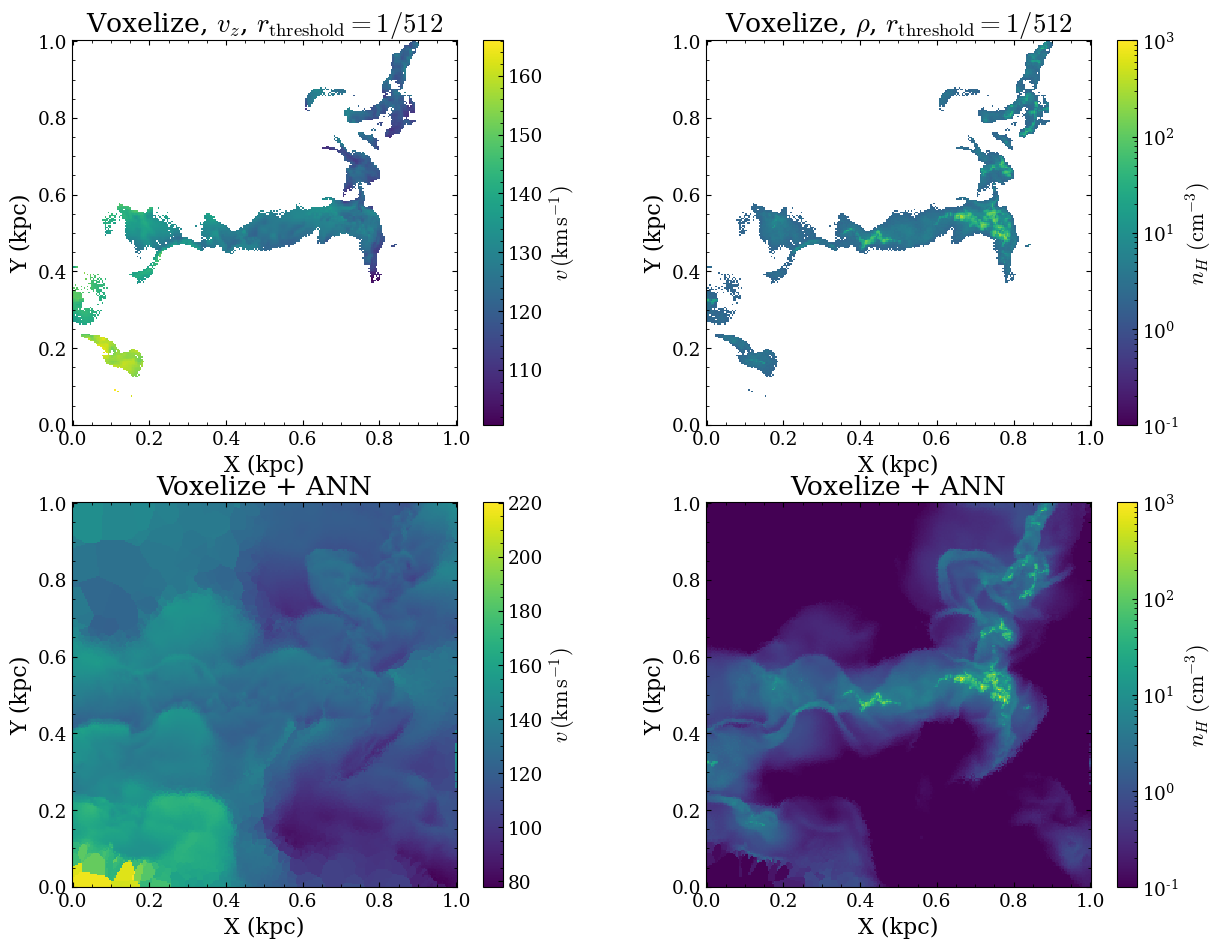

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(15, 11))

vxzField.vx[vxzField.get_density() <= density_threshold] = np.nan   # For demonstration purpose
vxzField.vz[vxzField.get_density() <= density_threshold] = np.nan   # density below threshold is shown white
vxzField.vy[vxzField.get_density() <= density_threshold] = np.nan
vxzField.mass[vxzField.get_density() <= density_threshold] = np.nan

vxzField.plot_velocity_slice(component=0, index=vxzField.Nsize//2, axis=2, ax=ax[0,0])
ax[0,0].set_title("Voxelize, $v_z$, $r_\\mathrm{{threshold}}=1/512$")
vxzANNField.plot_velocity_slice(component=0, index=vxzANNField.Nsize//2, axis=2, ax=ax[1,0])
ax[1,0].set_title("Voxelize + ANN")
vxzField.plot_density_slice(index=vxzField.Nsize//2, axis=2, ax=ax[0,1])
ax[0,1].set_title("Voxelize, $\\rho$, $r_\\mathrm{{threshold}}=1/512$")
vxzANNField.plot_density_slice(index=vxzANNField.Nsize//2, axis=2, ax=ax[1,1])
ax[1,1].set_title("Voxelize + ANN")
plt.show()

Test conservation, for different density thresholds and different resolutions. 
- Conserved to what percentage? 
- How does it change with density threshold? 
- How does it change with resolution?

In [15]:
import vpower as vp
vp.check_conservation(allPar, vxzANNField)

Total mass of particles: 1.260e-03
Total mass after interpolation: 1.374e-03
Total mass restored by 109.099%


Total momentum of particles: [ 0.16640169  0.2250191  -0.00676618]
Total momentum after interpolation: [ 0.18077693  0.24537268 -0.00739103]
Total momentum restored by (108.639%, 109.045%, 109.235%)




Total kinetic energy of particles: 3.141e+01
Total kinetic energy after interpolation: 3.412e+01
Total kinetic energy restored by 108.632%


### Results
##### Combination by 'maximize'
| Radii threshold | Density threshold | Resolution | Mass restored | Momentum restored | Kinetic energy restored |
|-----------------|-------------------|------------|---------------|-------------------|-------------------------|
| 1/512   |         10x       | 256        | 109.099%      | (108.639%, 109.045%, 109.235%) | 108.632%       |
##### Combination by 'stitching'
| Radii threshold | Density threshold | Resolution | Mass restored | Momentum restored | Kinetic energy restored |
|-----------------|-------------------|------------|---------------|-------------------|-------------------------|
| 0.0 (ANN only)   |         10x       | 256        | 98.497%       | (98.429%, 98.457%, 98.103%) | 98.384%       |
| 0.0 (ANN only)   |         10x       | 512        | 98.600%       | (98.551%, 98.574%, 98.895%) | 98.521%       |
| 1/512           |         10x       | 256        | 98.876%       | (98.787%, 98.850%, 99.157%) | 98.758%       |
| 1/512           |         10x       | 512        | 103.780%      | (103.863%, 103.768%, 103.970%) | 103.796%   |
| 1/256           |         10x       | 256        | 100.253%      | (100.291%, 100.189%, 100.700%) | 100.186%   |
| 1/256           |         10x       | 512        | 101.865%      | (101.919%, 101.770%, 102.362%) | 101.779%   |
| 1.0 (Voxelize mostly) |         10x       | 256        | 100.023%      | (100.012%, 100.015%, 99.549%) | 99.998%     |
| 1.0 (Voxelize mostly) |         10x      | 512        | 100.212%      | (100.196%, 100.202%, 99.720%) | 100.187%    |